In [19]:
import sys
import os

root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(root)

In [20]:
import numpy as np
import nest
import matplotlib.pyplot as plt

from params import pyr_hcamp_deco2012
from params import int_hcamp_deco2012



In [21]:
#Helper functions

def plot_vms_from_device(device, id_list):
    plt.figure(figsize=(18, 5))
    plt.title(f'Membrane potential(s) for Neuron(s) {id_list}')
    for id in id_list:
        ts = device.get('events')['times'][::id]
        vms = device.get('events')['V_m'][::id]
        plt.plot(ts, vms)
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage (mV)')
    

In [22]:
nest.rng_seed = 1
np.random.seed(1)

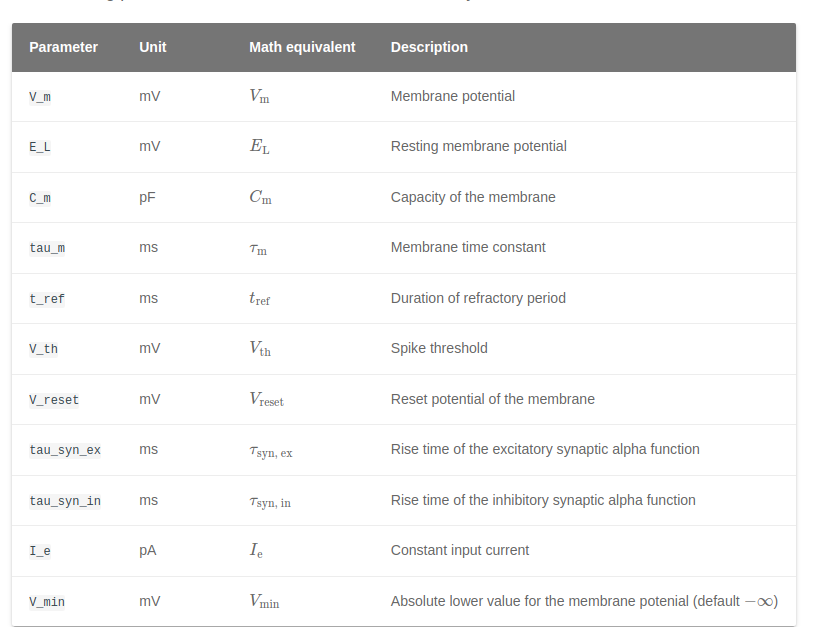

In [23]:
#Runtime
runtime = 200

#Gamma rate
gamma_rate = 40

#Theta rate 
theta_rate = 7

In [24]:
#Pyramidal neurons
ca1 = nest.Create('iaf_psc_alpha', n=206, params=pyr_hcamp_deco2012.params)
dVms = {"V_m": ca1.get('E_L')[0] + np.random.normal((ca1.get('V_th')[0]-ca1.get('E_L')[0])/2, 3, len(ca1))}

#Inter-neurons
inter = nest.Create('iaf_psc_alpha', n=20, params=int_hcamp_deco2012.params)


In [25]:
#External inputs
ec_input = nest.Create('poisson_generator')
ec_input.set(rate=gamma_rate)
ec_parrot = nest.Create('parrot_neuron', n=20)
nest.Connect(ec_input, ec_parrot)

ca3_input = nest.Create('poisson_generator')
ca3_input.set(rate=gamma_rate)
ca3_parrot = nest.Create('parrot_neuron', n=20)
nest.Connect(ca3_input, ca3_parrot)

ms_input = nest.Create('poisson_generator')
ms_input.set(rate=theta_rate)
ms_parrot = nest.Create('parrot_neuron', n=10)
nest.Connect(ms_input, ms_parrot)

In [26]:
#Within-cell connections
nest.Connect(ca1, ca1, conn_spec = {'rule': 'pairwise_bernoulli', 'p': 0.2}, syn_spec={'weight': 20})
nest.Connect(inter, ca1, syn_spec={'weight': -10})

In [27]:
#Intra-cellular connections
nest.Connect(ec_parrot, ca1, syn_spec={'weight': 35})
nest.Connect(ec_parrot, inter, syn_spec={'weight': 16})
nest.Connect(ca3_parrot, ca1, syn_spec={'weight': 29})
nest.Connect(ca3_parrot, inter, syn_spec={'weight': 24})
nest.Connect(ms_parrot, inter, syn_spec={'weight': -5})

In [28]:
#Monitoring connections
Vm_recorder = nest.Create('multimeter')
Vm_recorder.set(record_from=['V_m'])
nest.Connect(Vm_recorder, ca1)
spike_recorder = nest.Create('spike_recorder')
nest.Connect(ca1, spike_recorder)

In [29]:
nest.Simulate(runtime)


Nov 28 16:38:28 NodeManager::prepare_nodes [Info]: 
    Preparing 562 nodes for simulation.

Nov 28 16:38:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 562
    Simulation time (ms): 200
    Number of OpenMP threads: 1
    Not using MPI

Nov 28 16:38:28 SimulationManager::run [Info]: 
    Simulation finished.


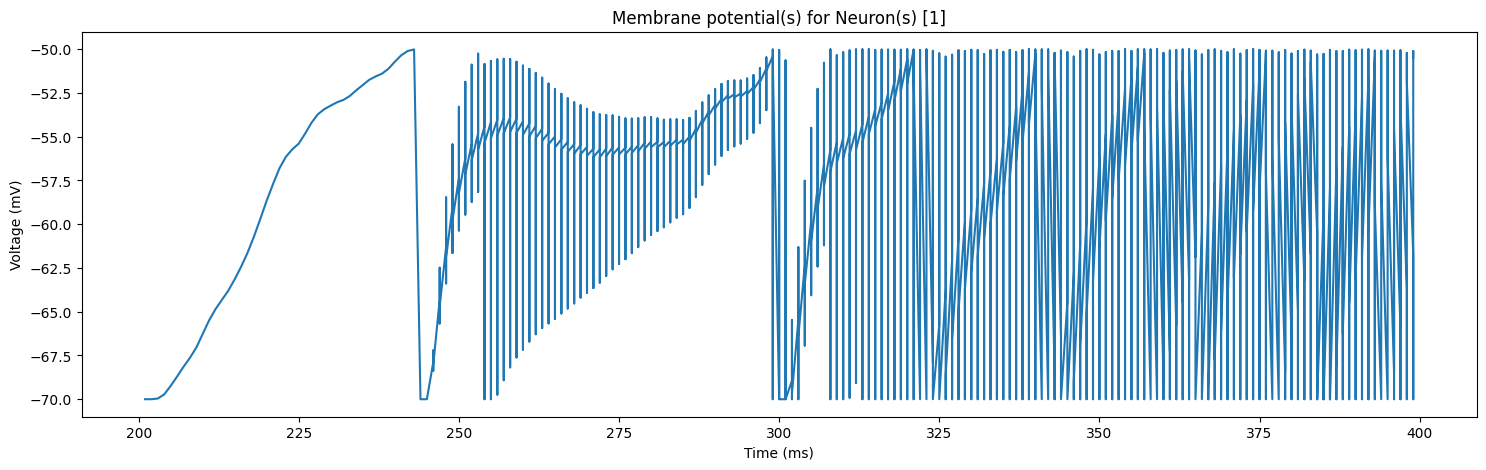

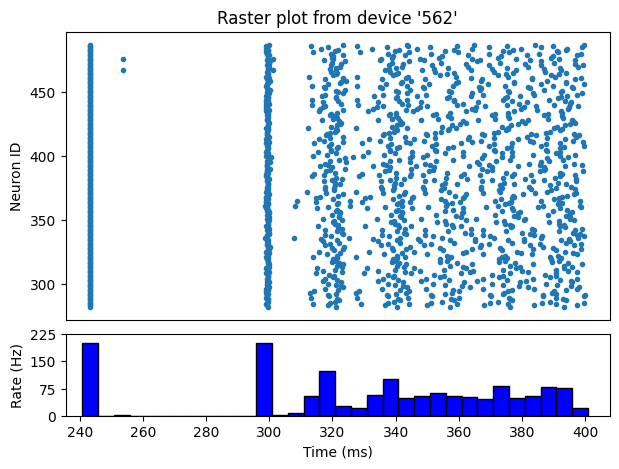

In [30]:
plot_vms_from_device(Vm_recorder, [1])
nest.raster_plot.from_device(spike_recorder)